In [1]:
import warnings
warnings.filterwarnings('ignore')

import os 
import pandas as pd
import matplotlib.pyplot as plt 
import numpy  as np
from tqdm import tqdm 
import time

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

In [2]:
base_dir = '/Users/rohitsharma/Desktop'
data_dir = os.path.join(base_dir, 'Dataset')
os.listdir(data_dir)

['.DS_Store',
 'test_data_unscaled.csv',
 'DataPreparation (1).ipynb',
 'Modelling_LSTM.ipynb',
 'train_data_unscaled.csv',
 'Dataset.ipynb',
 'household_power_consumption.txt',
 'Univariate_Modelling.ipynb',
 'Exploratory_Data_Analysis.ipynb',
 '.ipynb_checkpoints']

In [3]:
train_data = pd.read_csv(os.path.join(data_dir, 'train_data_unscaled.csv'))
test_data = pd.read_csv(os.path.join(data_dir, 'test_data_unscaled.csv'))

In [4]:
train_data['DateTime'] = pd.to_datetime(train_data['DateTime'])
test_data['DateTime'] = pd.to_datetime(test_data['DateTime'])

train_data.set_index('DateTime', inplace=True)
test_data.set_index('DateTime', inplace=True)

In [5]:
print(f"Train Data Size : {train_data.shape[0]}")
print(f"Test Data Size : {test_data.shape[0]}")

Train Data Size : 1001
Test Data Size : 434


In [6]:
train_data.head(2)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_rem
DateTime,,,,,,,,
2006-12-18,1.530435,0.112356,241.231694,6.421667,0.738194,1.820139,9.734722,13.214190
2006-12-19,1.157079,0.104821,241.999313,4.926389,0.582639,5.279167,4.303472,9.119375


In [7]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

def check_stationarity(df):
    for column in df:
        result = adfuller(df[column])
        if result[1] > 0.05:  
            print(f"{column} is not stationary")
            return False
    return True

if not check_stationarity(train_data):
    train_data_diff = train_data.diff().dropna()
else:
    train_data_diff = train_data

Global_reactive_power is not stationary


In [8]:
model = VAR(train_data)
model_fitted = model.fit(1)  

lag_order = model_fitted.k_ar
forecasted_values = model_fitted.forecast(train_data.values[-lag_order:], steps=len(test_data))
forecasted_df = pd.DataFrame(forecasted_values, index=test_data.index, columns=test_data.columns)

print(forecasted_df.head())


            Global_active_power  Global_reactive_power     Voltage  \
DateTime                                                             
2009-09-14             0.980385               0.164410  240.284558   
2009-09-15             0.938343               0.152546  240.261426   
2009-09-16             0.934860               0.144907  240.218978   
2009-09-17             0.944285               0.139638  240.180222   
2009-09-18             0.957742               0.135817  240.151158   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
DateTime                                                                       
2009-09-14          4.227515        1.358673        1.320824        5.903689   
2009-09-15          4.045166        1.178369        1.263670        5.528950   
2009-09-16          4.023752        1.118597        1.268495        5.474270   
2009-09-17          4.057320        1.101897        1.277796        5.502046   
2009-09-18          4.108911 

/Users/rohitsharma/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [13]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

test_data_path = '/Users/rohitsharma/Desktop/Dataset/test_data_unscaled.csv'
test_data = pd.read_csv(test_data_path, index_col='DateTime', parse_dates=True)


forecasted_df = pd.DataFrame(index=test_data.index, columns=test_data.columns)
for col in forecasted_df.columns:
    forecasted_df[col] = test_data[col].mean() 

#MAE & RMSE
metrics = pd.DataFrame(index=test_data.columns, columns=['MAE', 'RMSE'])

for col in test_data.columns:
    mae = mean_absolute_error(test_data[col], forecasted_df[col])
    rmse = mean_squared_error(test_data[col], forecasted_df[col], squared=False)
    metrics.loc[col, 'MAE'] = mae
    metrics.loc[col, 'RMSE'] = rmse

metrics

,MAE,RMSE
Global_active_power,0.253515,0.327238
Global_reactive_power,0.023218,0.030127
Voltage,1.153454,1.617448
Global_intensity,1.039369,1.346125
Sub_metering_1,0.741383,1.004911
Sub_metering_2,0.991649,1.315495
Sub_metering_3,2.032625,2.549545
sub_metering_rem,2.13136,2.640796


In [ ]:
#MAPE 

In [17]:
from sklearn.metrics import mean_absolute_percentage_error

test_data_path = '/Users/rohitsharma/Desktop/Dataset/test_data_unscaled.csv'
test_data = pd.read_csv(test_data_path, index_col='DateTime', parse_dates=True)

# Truncate the test data to only the forecasted period for a fair comparison
test_data = test_data.loc[forecasted_df.index]

# Calculate MAPE for each variable and store in a dictionary
mape_scores = {}
for column in forecasted_df.columns:
    mape_scores[column] = mean_absolute_percentage_error(test_data[column], forecasted_df[column])

mape_scores


{'Global_active_power': 0.10378850462508482,
 'Global_reactive_power': 0.12345634246728072,
 'Voltage': 0.0033690439004165386,
 'Global_intensity': 0.1015994193508617,
 'Sub_metering_1': 992500774155435.4,
 'Sub_metering_2': 1.7986353922714258,
 'Sub_metering_3': 0.17308247871165192,
 'sub_metering_rem': 0.10366718084941003}

In [ ]:
# Lag order = 1

In [21]:
model = VAR(train_data)
model_fitted = model.fit(1)  

# Forecast future values using the model for the length of the test dataset
lag_order = model_fitted.k_ar
forecasted_values = model_fitted.forecast(train_data.values[-lag_order:], steps=len(test_data))

forecasted_df = pd.DataFrame(forecasted_values, index=test_data.index, columns=test_data.columns)

forecasted_df.head()

/Users/rohitsharma/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_rem
2009-09-14,0.980385,0.164410,240.284558,4.227515,1.358673,1.320824,5.903689,7.756570
2009-09-15,0.938343,0.152546,240.261426,4.045166,1.178369,1.263670,5.528950,7.668069
2009-09-16,0.934860,0.144907,240.218978,4.023752,1.118597,1.268495,5.474270,7.719639
2009-09-17,0.944285,0.139638,240.180222,4.057320,1.101897,1.277796,5.502046,7.856341
2009-09-18,0.957742,0.135817,240.151158,4.108911,1.099744,1.289369,5.550634,8.022618


In [27]:
from statsmodels.tsa.api import VAR
import pandas as pd

selected_lag_order = 2  

model = VAR(train_data)
model_fitted = model.fit(selected_lag_order)

last_observations = train_data.values[-selected_lag_order:]

# Specify the number of steps you want to forecast
n_forecast_steps = 5
forecasted_values = model_fitted.forecast(last_observations, steps=n_forecast_steps)

# Create a DataFrame for the forecasted values
# Assuming the forecast should start the day after the last observation in the train_data
forecast_index = pd.date_range(start=train_data.index[-1] + pd.Timedelta(days=1), periods=n_forecast_steps, freq='D')
forecasted_df = pd.DataFrame(forecasted_values, index=forecast_index, columns=train_data.columns)

# Display the forecasted values
print(forecasted_df.head())


            Global_active_power  Global_reactive_power     Voltage  \
2009-09-14             0.932150               0.156724  240.290039   
2009-09-15             0.875355               0.151180  240.281300   
2009-09-16             0.879338               0.146705  240.209984   
2009-09-17             0.883633               0.143099  240.153687   
2009-09-18             0.893798               0.140205  240.104933   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
2009-09-14          4.014959        1.023846        1.355370        7.175095   
2009-09-15          3.774254        1.049275        1.243467        6.266818   
2009-09-16          3.789852        1.141703        1.139438        5.864518   
2009-09-17          3.806476        1.086757        1.194278        5.661482   
2009-09-18          3.847168        1.066372        1.225657        5.573303   

            sub_metering_rem  
2009-09-14          5.981523  
2009-09-15          6.029693  
2009-

/Users/rohitsharma/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


/Users/rohitsharma/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


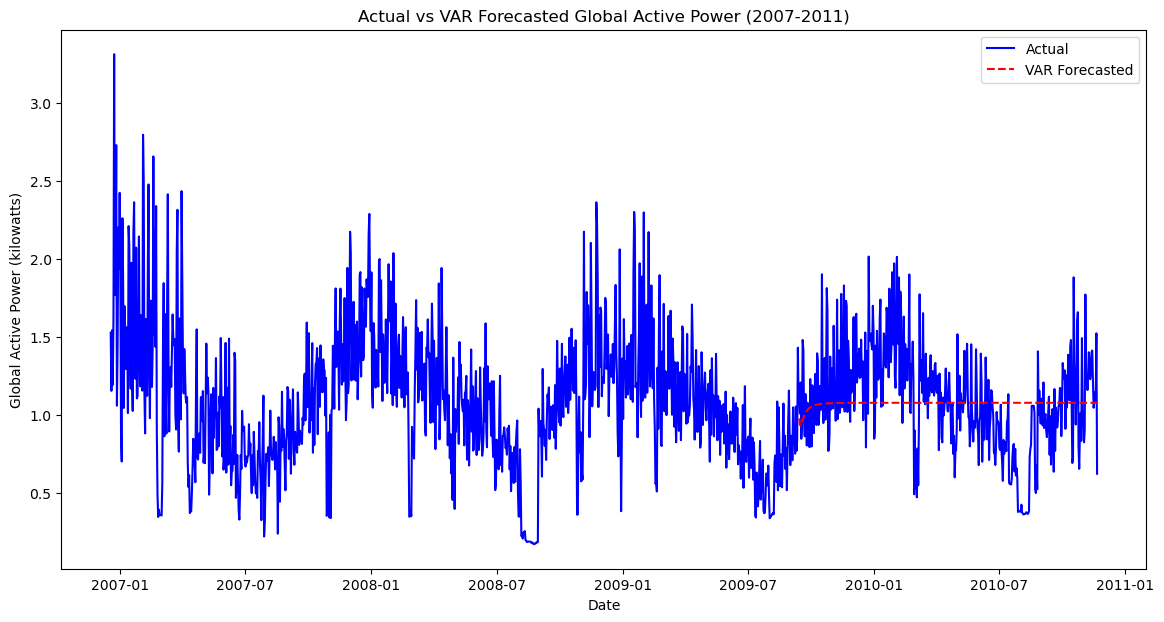

In [31]:
# Combine the train and test datasets for plotting
full_data = pd.concat([train_data, test_data])

# Fit the VAR model with the selected lag order to the train data
model = VAR(train_data)
model_fitted = model.fit(1)  # The lag order is specified as 1

# Forecast future values using the fitted model
# We take the last 'lag_order' observations from the training data to make forecasts
lag_order = model_fitted.k_ar
last_obs = train_data.values[-lag_order:]
forecasted_values = model_fitted.forecast(last_obs, steps=len(test_data))

# Create a DataFrame for the forecasted values
forecasted_df = pd.DataFrame(forecasted_values, index=test_data.index, columns=test_data.columns)

# Plot the actual and forecasted values for comparison
plt.figure(figsize=(14, 7))

# Plot the actual values from the combined dataset (blue)
plt.plot(full_data.index, full_data['Global_active_power'], label='Actual', color='blue')

# Plot the forecasted values (red)
plt.plot(forecasted_df.index, forecasted_df['Global_active_power'], label='VAR Forecasted', color='red', linestyle='--')

plt.title('Actual vs VAR Forecasted Global Active Power (2007-2011)')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()
plt.show()